# A Q-Learning implementation for PymGrid

Don't forget to add your own path in sys

In [1]:
import sys
sys.path.append('C:/Users/Tanguy LEVENT/Documents/Ploutos/Projet_Ploutos/pymgrid/')
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time

### Generate Microgrids

In [2]:
path = sys.path[len(sys.path)-1]
env = mg.MicrogridGenerator(path =path,nb_microgrid=2)
env.generate_microgrid(verbose = True)

,load,cost_loss_load,cost_overgeneration,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,grid_power_import,grid_power_export,grid_price_import,grid_price_export
0,7299388,10000,1,7372381.9,0.2,625,625,2500,0.9,0.2,1,0.3,2836,2836,0.3,0
1,8080212,10000,1,4282512.4,0.2,1153,1153,4612,0.9,0.2,1,0.3,3762,3762,0.3,0


Now I print the architecture of the random generated microgrid. I understand that I have an on-grid microgrid with battery

In [3]:
for i in range(env.nb_microgrids):
    
    print("Microgrid {} architecture: {}".format(int(i), str(env.microgrids[i].architecture)))

Microgrid 0 architecture: {'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}
Microgrid 1 architecture: {'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}


For sake of confort I decide to rename my microgrid


In [4]:
mg0 = env.microgrids[0]
mg1 = env.microgrids[1]

I decide to plot my grid status in order to see if sometime the grid can be disconnected to the grid. Here we observe that the microgrid is always connected to the utility grid

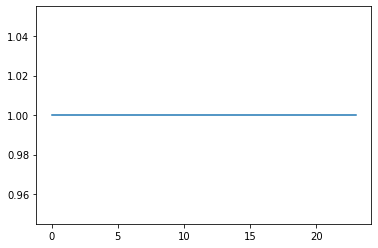

In [5]:
plt.plot(mg0.forecast_grid_status())

Now I decide to call print_info() method to print all the informations at once 

In [6]:
mg0.print_info()

Microgrid parameters


,load,cost_loss_load,cost_overgeneration,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,grid_power_import,grid_power_export,grid_price_import,grid_price_export
0,7299388,10000,1,7372381.9,0.2,625,625,2500,0.9,0.2,1,0.3,2836,2836,0.3,0


Architecture:
{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}
Actions: 
Index(['pv_consummed', 'battery_charge', 'battery_discharge', 'grid_import',
       'grid_export'],
      dtype='object')
Control dictionnary:
['pv_consummed', 'battery_charge', 'battery_discharge', 'grid_import', 'grid_export']
Status: 
Index(['load', 'hour', 'pv', 'battery_soc', 'capa_to_charge',
       'capa_to_discharge', 'grid_status'],
      dtype='object')
Has run mpc baseline:
False
Has run rule based baseline:
False


In [7]:
print("Penetration PV Microgrid 1 :", round(mg0.parameters["PV_rated_power"][0]/mg0.parameters["load"][0]*100,2), "%")
print("Penetration PV Microgrid 2 :", round(mg1.parameters["PV_rated_power"][0]/mg1.parameters["load"][0]*100,2), "%")

Penetration PV Microgrid 1 : 101.0 %
Penetration PV Microgrid 2 : 53.0 %


What are my state variables? To our case we want to choose the current net_laod (load-pv) and the current battery capacity

In [8]:
net_load = mg0.load-mg0.pv
print("My current net_load is equal to {:0.4} kWh and my current battery capacity is {}".format(net_load, mg0.battery.capacity))


My current net_load is equal to 618.3 kWh and my current battery capacity is 2500


Plot PV and Load for the next 24 hours

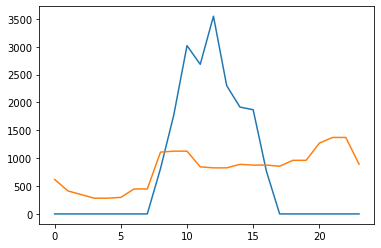

In [10]:
plt.plot(mg0.forecast_pv())
plt.plot(mg0.forecast_load())


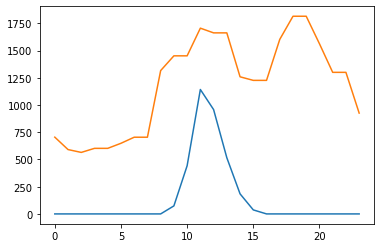

In [11]:
plt.plot(mg1.forecast_pv())
plt.plot(mg1.forecast_load())


Plot for 4 days. I need to change the horizon time. Don't forget to get it back at the right value afterward

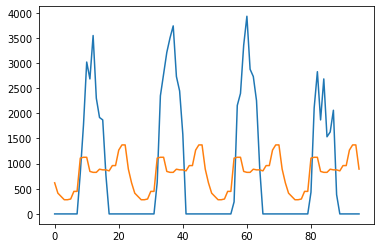

In [12]:
mg0.set_horizon(24*4)
plt.plot(mg0.forecast_pv())
plt.plot(mg0.forecast_load())

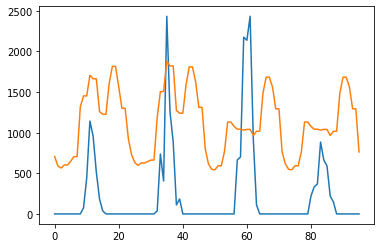

In [13]:
mg1.set_horizon(24*4)
plt.plot(mg1.forecast_pv())
plt.plot(mg1.forecast_load())

What is my net_load over 4 days?

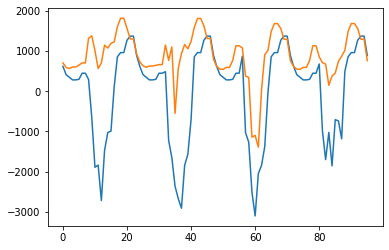

In [14]:
plt.plot(mg0.forecast_load()-mg0.forecast_pv())
plt.plot(mg1.forecast_load()-mg1.forecast_pv())

I get back my horizon at 24 steps/hours

In [15]:
mg0.set_horizon(24)
mg1.set_horizon(24)

### Design of the agent

First we need to define the different actions our agent will have to take in the microgrid environment. As a result we create a function actions_agent(). The run() fonction is similar to step() of OpenAI Gym, nevertheless run() take a dictionnary as an input. So we need to return a dictionary of actions related to control_dict. So sake of simplicity we consider that the agent can take only one of the 5 actions defined at the full rate of the net_load.

What action can I take? 

In [16]:
mg0.get_control_dict()

['pv_consummed',
 'battery_charge',
 'battery_discharge',
 'grid_import',
 'grid_export']

First we need to define the different actions our agent will take. Let's set a new fonction call action_agent(). Don't forget to return a dictionnary for the run function

In [19]:
#action 0: battery_charge
#action 1: battery_discharge
#action 2: grid_import
#action 3: grid_export

def actions_agent(mg0, action):
 
    
    pv = mg0.pv
    load = mg0.load
    
    net_load = load - pv
    
    capa_to_charge = mg0.battery.capa_to_charge
    p_charge_max = mg0.battery.p_charge_max
    p_charge = max(0,min(-net_load, capa_to_charge, p_charge_max))
    
    capa_to_discharge = mg0.battery.capa_to_discharge
    p_discharge_max = mg0.battery.p_discharge_max
    p_discharge = max(0,min(net_load, capa_to_discharge, p_discharge_max))

          
    if action == 0:
        
        if p_charge > 0:
            
        
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': p_charge,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export':max(0,pv - min(pv,load) - p_charge)
                           }
        else:
            
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': net_load,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export':max(0,pv - min(pv,load) - p_charge)
                           }

            
            
    #décharger full + export le reste
    elif action ==1:
        
        if p_discharge > 0:
        
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': 0,
                            'battery_discharge': p_discharge,
                            'grid_import': max(0,load - min(pv,load) - p_discharge),
                            'grid_export':0
                           }
        else:
            
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': 0,
                            'battery_discharge': net_load,
                            'grid_import': max(0,load - min(pv,load) - p_discharge),
                            'grid_export':0
                           }

        
    elif action ==2:
        
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': abs(net_load),
                        'grid_export':0
                       }
        
    elif action == 3:
        
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':abs(net_load)
                       }
    
    return control_dict

Now I create functions for the SARSA agent.
The first one is to initialize my Q table. I need to round the state to reduce the state space.

In [20]:
def init_qtable(mg0, nb_action):
    
    net_load = mg0.forecast_load() - mg0.forecast_pv()
    state = []
    Q = {}

    for i in range(int(net_load.min()-1),int(net_load.max()+2)):
        
        for j in np.arange(round(mg0.battery.soc_min,1),round(mg0.battery.soc_max+0.1,1),0.1):
            
            j = round(j,1)
            state.append((i,j)) 

    #Initialize Q(s,a) at zero
    for s in state:

        Q[s] = {}

        for a in range(nb_action):

            Q[s][a] = 0

    return Q

I define a function for my exploration strategy. Here I've selected the epsilon greedy decreasing strategy

In [21]:
def espilon_decreasing_greedy(action, epsilon, nb_action):
    
    p = np.random.random()

    if p < (1 - epsilon):
        randomm=0
        return action, randomm

    else: 
        randomm=1
        return np.random.choice(nb_action), randomm

In [22]:
def max_dict(d):

    max_key = None
    max_val = float('-inf')


    for k,v in d.items():

        if v > max_val:

            max_val = v
            max_key = k

    return max_key, max_val

I also need to define a function to decrease and update my espilon 

In [23]:
def update_epsilon(epsilon):
    
    epsilon = epsilon - epsilon *0.02
    
    if epsilon < 0.1:
        
        epsilon = 0.1
    
    return epsilon

In [24]:
def change_name_action(idx):
    
    #action 0: battery_charge
    #action 1: battery_discharge
    #action 2: grid_import
    #action 3: grid_export
    
    if idx == 0:
        
        action_name = "charge"
    elif idx == 1:
        action_name = "discharge"
    elif idx == 2:
        
        action_name = "import"
        
    else:
        
        action_name = "export"
    
    return action_name

In [25]:
def print_welcome(idx):
    
    if idx == 0:
        print("------------------------------------")
        print("|        WELCOME TO PYMGRID        |")
        print("------------------------------------")
    elif idx == 1:
        
        print("t -     STATE  -  ACTION - COST")
        print("================================")
    

Now I define my agent function

In [26]:
def training_Q_Learning(mg,horizon):
    
    nb_action = 4
    Q = init_qtable(mg,nb_action)
    nb_state = len(Q)
    nb_episode = 100
    alpha = 0.1
    epsilon = 0.99
    gamma = 0.99
    
    record_cost = []
    t0 = time.time()
    t = t0
    print_training = "Training Progressing .   "
    print_welcome(0)
    print("\n")
    for e in range(nb_episode+1):
        
        if e == 0:
            value_print="\rEpisode " + str(e) +"/" + str(nb_episode)
            sys.stdout.write(value_print)
            sys.stdout.flush()
        
        else:
            
            now = time.time()
            
            if e == 1 or e == 50 or e == 100 or e == 200 or e == 300 or e == 400  or e == 450  or e == 485 or e == nb_episode-5:
                diff_time_t = now - t 
                total_time = (nb_episode+1) * diff_time_t
            
            now = time.time()
            
            diff_time = now - t0
            time_remaining = total_time - diff_time
            
            t = time.time()
        
        if e % 10 == 0:
        
            if print_training == "Training Progressing .   ":
                
                print_training = "Training Progressing ..  "
                
            elif print_training == "Training Progressing ..  ":
            
                print_training = "Training Progressing ... "
            
            else:
                
                print_training = "Training Progressing .   "

        value_print="\r"+ print_training +"Episode " + str(e) +"/" + str(nb_episode) 
        sys.stdout.write(value_print)
        sys.stdout.flush()
            
        episode_cost = 0
        mg.reset()
        
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s = (net_load, soc)
        
        a = max_dict(Q[s])[0]
        a,randomm = espilon_decreasing_greedy(a, epsilon, nb_action)
        
        
        for i in range (horizon):
            
            action = actions_agent(mg,a)
            status = mg.run(action)
            r = -mg.get_cost() - mg.penalty(0.5)
            episode_cost += mg.get_cost()
            net_load = round(mg.load - mg.pv)
            soc = round(mg.battery.soc,1)
            s_ = (net_load, soc)
            a_ = max_dict(Q[s_])[0]
            
            if i == horizon-1:
                
                Q[s][a] += alpha*(r - Q[s][a])
      
            else:
             
                old_Q = Q[s][a]
                target = r + gamma*Q[s_][a_]
                td_error = target - Q[s][a]
                Q[s][a] = (1-alpha) * Q[s][a] + alpha * td_error
                
            s, a = s_, a_
       
        epsilon = update_epsilon(epsilon)
        
    return Q

In [27]:
def testing_Q_Learning(mg, Q,horizon):
    
    mg.reset()
    net_load = round(mg.load - mg.pv)
    soc = round(mg.battery.soc,1)
    s = (net_load, soc)
    a = max_dict(Q[s])[0]
    total_cost = 0
    print_welcome(1)
    for i in range (horizon):

        action_name = change_name_action(a)
        action = actions_agent(mg, a)
        status = mg.run(action)
        cost = mg.get_cost()
        total_cost += cost
        if i < 10:
            print(i," -",(int(net_load),soc),action_name, round(total_cost,1), "€")
        else:
            print(i,"-",(int(net_load),soc),action_name, round(total_cost,1), "€")
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s_ = (net_load, soc)
        a_ = max_dict(Q[s_])[0]

        s, a = s_, a_

In [29]:
Q1 = training_Q_Learning(mg0,48)

------------------------------------
|        WELCOME TO PYMGRID        |
------------------------------------


Training Progressing ... Episode 100/100

In [30]:
testing_Q_Learning(mg0,Q1, 48)

t -     STATE  -  ACTION - COST
0  - (618, 0.2) import 185.5 €
1  - (413, 0.2) import 309.3 €
2  - (347, 0.2) import 413.4 €
3  - (282, 0.2) import 498.0 €
4  - (282, 0.2) import 582.5 €
5  - (296, 0.2) import 671.4 €
6  - (448, 0.2) import 805.8 €
7  - (448, 0.2) import 940.2 €
8  - (294, 0.2) import 1028.4 €
9  - (-647, 0.2) export 1028.4 €
10 - (-1893, 0.2) export 1028.4 €
11 - (-1839, 0.2) export 1028.4 €
12 - (-2720, 0.2) export 1028.4 €
13 - (-1474, 0.2) export 1028.4 €
14 - (-1028, 0.2) export 1028.4 €
15 - (-993, 0.2) export 1028.4 €
16 - (109, 0.2) import 1061.2 €
17 - (856, 0.2) import 1317.9 €
18 - (961, 0.2) import 1606.1 €
19 - (961, 0.2) import 1894.3 €
20 - (1269, 0.2) import 2275.0 €
21 - (1372, 0.2) import 2686.4 €
22 - (1372, 0.2) import 3097.9 €
23 - (891, 0.2) import 3365.3 €
24 - (618, 0.2) import 3550.8 €
25 - (413, 0.2) import 3674.6 €
26 - (347, 0.2) import 3778.7 €
27 - (282, 0.2) import 3863.3 €
28 - (282, 0.2) import 3947.8 €
29 - (296, 0.2) import 4036.7 €
3